# Create an ensemble forecast using dropout

The atmosphere is an inherently chaotic system. This means that even tiny errors in the initial conditions can cause large errors in the forecast even if a perfect model existed. Check out the famous [butterfly effect](https://en.wikipedia.org/wiki/Lorenz_system). But in addition to this, we have unknown model uncertainties in weather models.

What this means in essence is that we really need a large number of possible forecasts, what is called an ensemble, for a given weather situation to create a probabilistic forecast. This then allows us to say that there is a 30% chance of rain. For physical weather forecasts, these ensembles are created by using slightly different initial conditions and model physics.

What I am trying to do in the WeatherBench project is to create a purely data-driven forecast. For this we created a benchmark dataset. Check out the [paper](http://arxiv.org/abs/2002.00469). So far, in the benchmark and in my experiments I have only trained deterministic models, that is models that produce a single, "best" forecast. But as mentioned above, ideally we would produce a range of possible forecasts. The big question is how to do this with deep learning.

I see several possible methods:

1. Train a bunch of different models (e.g. different random seed or different hyperparameters)
1. Use different initial conditions.
1. If the model uses dropout, use dropout also during inference to introduce randomness.
1. Use a parametric approach: Forecast a PDF, e.g. a Gaussian, by predicting the paramters, e.g. mean and standard deviation. See some work I've done on this: https://doi.org/10.1175/MWR-D-18-0187.1
1. Use a GAN.

I have no idea which method works best, so we need to try it out.

I thought an easy place to start is to test the test-time dropout method. You task in this notebook is to implement this based on a model I already trained. BTW, this paper proposed the method: https://arxiv.org/pdf/1506.02142.pdf
 
So let's get started.

## Set up

This is my development branch of WeatherBench, which means things are not as nicely documented. Sorry about that. Regardless, let's import the modules we need. If you don't know what a function or class does, check out the definition in the `src` directory. Also check the requirements in the `environment.yml` file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [4]:
tf.__version__

'2.1.0'

In [ ]:
# You only need this if you are using a GPU
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

## Load the data

We are using the benchmark dataset. It comes in three different resolutions, for now I am just using the lowest resolution: 5.625 degrees. Download instructions can be found here: https://github.com/pangeo-data/WeatherBench. The entire dataset for this resolution takes up around 200GB. Since this is quite a lot I uploaded a single year of the data you need here: http://doi.org/10.5281/zenodo.3700685. In `test.zip`.

In [21]:
datadir = '/home/rasp/tmp/'  # Change this to where you downloaded the data

In [22]:
!ls $datadir

13-mean.nc			constants     u_component_of_wind
13-resnet_bn_dr_0.1.h5		geopotential  v_component_of_wind
13-resnet_bn_dr_0.1_weights.h5	temperature
13-std.nc			test.zip


These are all the parameters for the model and data generator that I use for the `train_nn.py` script.

In [25]:
exp_id = '13-resnet_bn_dr_0.1'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 
            'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 
            'constants': ['lsm','orography','lat2d']}
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = 1
dropout = 0.1  # This is the important one

batch_size = 32
nt_in = 1
l2 = 0
skip = True

The raw data is stored in the NetCDF format. I am using the awesome [xarray](http://xarray.pydata.org/en/stable/) package to read and manipulate the data.

In [26]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

Importantly we also need to load the mean and standard deviations we used to normalize the data during training.

In [28]:
mean = xr.open_dataarray('/home/rasp/tmp/13-mean.nc')
std = xr.open_dataarray('/home/rasp/tmp/13-std.nc')

In [29]:
dg_test = DataGenerator(
    ds, var_dict, lead_time, batch_size=batch_size, mean=mean, std=std,
    shuffle=False, output_vars=output_vars
)

DG start 11:24:51.718023
DG normalize 11:24:51.756040
DG load 11:24:51.776554
Loading data into RAM
DG done 11:24:55.238034


In [31]:
# You can index into the data generator to obain a feature/target pair
# [batch, x, y, channel]
X, y = dg_test[0]
X.shape, y.shape

((32, 32, 64, 15), (32, 32, 64, 2))

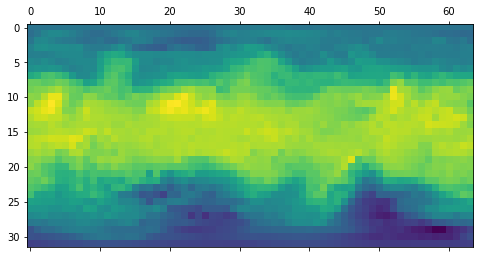

In [36]:
plt.matshow(y[0, :, :, 1])

## Load the model

Now let's load the pretrained model. Check the build resnet option .

In [33]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_test.data.lat), len(dg_test.data.lon), len(dg_test.data.level) * nt_in
    ),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout
)

In [34]:
model.compile('adam', 'mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 15)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  94208       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         activation[0][0]                 
______________________________________________________________________________________________

In [35]:
model.load_weights(f'{datadir}13-resnet_bn_dr_0.1_weights.h5')

## Create a deterministic prediction

The model has been trained to create a deterministic prediction. For this dropout is turned off during test time. Let's create a prediction for the first sample. Thanks to Tensorflow 2 we can tread the model as a function just like in PyTorch.

In [42]:
pred = model(X[:1]).numpy().squeeze(); pred.shape

(32, 64, 2)

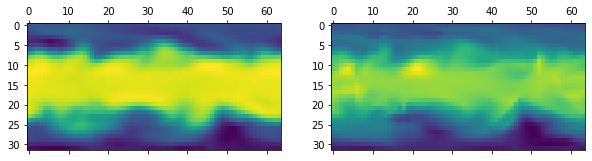

In [43]:
# Look at the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(pred[..., 0])
ax2.matshow(pred[..., 1])

Task: Can you figure out what is plotted in these two images? Hint: Check out what is happening in the data generator.

## Create an ensemble using test-time dropout

Now it's your turn. The pretrained model contains several dropout layers which are only active during training. Your job is to turn dropout on during inference as well. This should result in a model that creates a slightly different prediction every time. Hint: Google "Keras test-time dropout".

Once you have a model with test-time dropout on, create a bunch of forecasts (an ensemble) for the same input. Then pick one point on the map (bonus points if you pick the point closes to Munich!) and create a histogram of the temperature ensemble predictions.

Next, remember that the features and targets were normalized inside the data generator. Can you recover the real units (Kelvin). This could be a little tricky, so no worries if you can't figure it out on your own) but if you check out the `create_predictions` function in `src/data_generator`, you will find the answer.

The predictions of the model are pure numpy arrays. Maybe you find it helpful to convert them to an xarray Dataarray with coordinates.

In [45]:
ds.t.isel(time=0).sel(level=850)

<xarray.DataArray 't' (lat: 32, lon: 64)>
dask.array<getitem, shape=(32, 64), dtype=float32, chunksize=(32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
    level    int32 850
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    time     datetime64[ns] 2018-01-01
Attributes:
    units:          K
    long_name:      Temperature
    standard_name:  air_temperature